In [1]:
#!pip install --quiet pytorch-lightning
#!pip install --quiet tqdm
#!nvidia-smi

In [2]:
import seaborn as sns  #Visualization
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib


import pandas as pd   #preprocessing
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler


import torch          #modelling
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

from keras.preprocessing import sequence

import os
from IPython.utils import io

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12,8

tqdm.pandas()

In [4]:
pl.seed_everything(8);

Global seed set to 8


In [5]:
folder_path = "Predictions/correlation_prediction_daily"

try:
    os.mkdir(f'{folder_path}')
except:
    pass

    
N_EPOCHS = 50
BATCH_SIZE = 7
SEQUENCE_LENGTH = 7
N_HIDDEN = 64
N_LAYERS = 4
PATIENCE = 10
LEARNING = 0.0005

In [6]:
def features_dataframe(df, corr):
    rows = []
    '''
['rec_id', 'datetime', 'year', 'month', 'temp', 'atemp', 'humidity', 'windspeed', 'total_count',
 'season_1', 'season_2', 'season_3', 'season_4', 'is_workingday_0', 'is_workingday_1', 'is_holiday_0',
 'is_holiday_1', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3', 'weekday_0',
 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day']
 
    '''

    for _, row in df.iterrows():
        row_data = dict(
            total_count = row.total_count,
        )
        for column in corr:
            row_data[column] = row[column]
            
        rows.append(row_data)
    
    features_df = pd.DataFrame(rows)

    return features_df

def train_test_spliter(ratio,features_df ):
    train_size = int(len(features_df)-90)
    train_df, test_df = features_df[:train_size], features_df[train_size + 1:]

    return train_df, test_df, train_size

def data_scaler(train_df,test_df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train_df)

    train_df = pd.DataFrame(
        scaler.transform(train_df),
        index = train_df.index,
        columns = train_df.columns
        )

    test_df = pd.DataFrame(
        scaler.transform(test_df),
        index = test_df.index,
        columns = test_df.columns
        )
  
    return train_df, test_df, scaler


def create_sequences (input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)

    for i in (range(data_size - sequence_length)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        sequences.append((sequence,label))
    
    return sequences

def descale(descaler, values):
    values_2d=np.array(values)[:,np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()



class BTCDataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

class BTCPriceDataModule(pl.LightningDataModule):

    def __init__(self, train_seqeunces,test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self,stage=None):
        self.train_dataset = BTCDataset(self.train_sequences)
        self.test_dataset = BTCDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
        )


class PricePredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden = N_HIDDEN, n_layers = N_LAYERS):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden,1)

    def forward(self,x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)
    

class BTCPricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model=PricePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels= None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('train_loss', loss, prog_bar = True, logger=False)
        return loss

    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('val_loss', loss, prog_bar = True, logger=False)
        return loss

    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('test_loss', loss, prog_bar = True, logger=False)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr = LEARNING)
        

In [7]:
Bikes_df = pd.read_csv('Bike_Sharing_Daily.csv')

corr_values = [0,0.05,0.1,0.15,0.2,0.25]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 123 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.495     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Correlation Threshold:  0
Features selected: ['rec_id', 'year', 'month', 'temp', 'atemp', 'humidity', 'windspeed', 'total_count', 'season_1', 'season_2', 'season_3', 'season_4', 'is_workingday_0', 'is_workingday_1', 'is_holiday_0', 'is_holiday_1', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day']


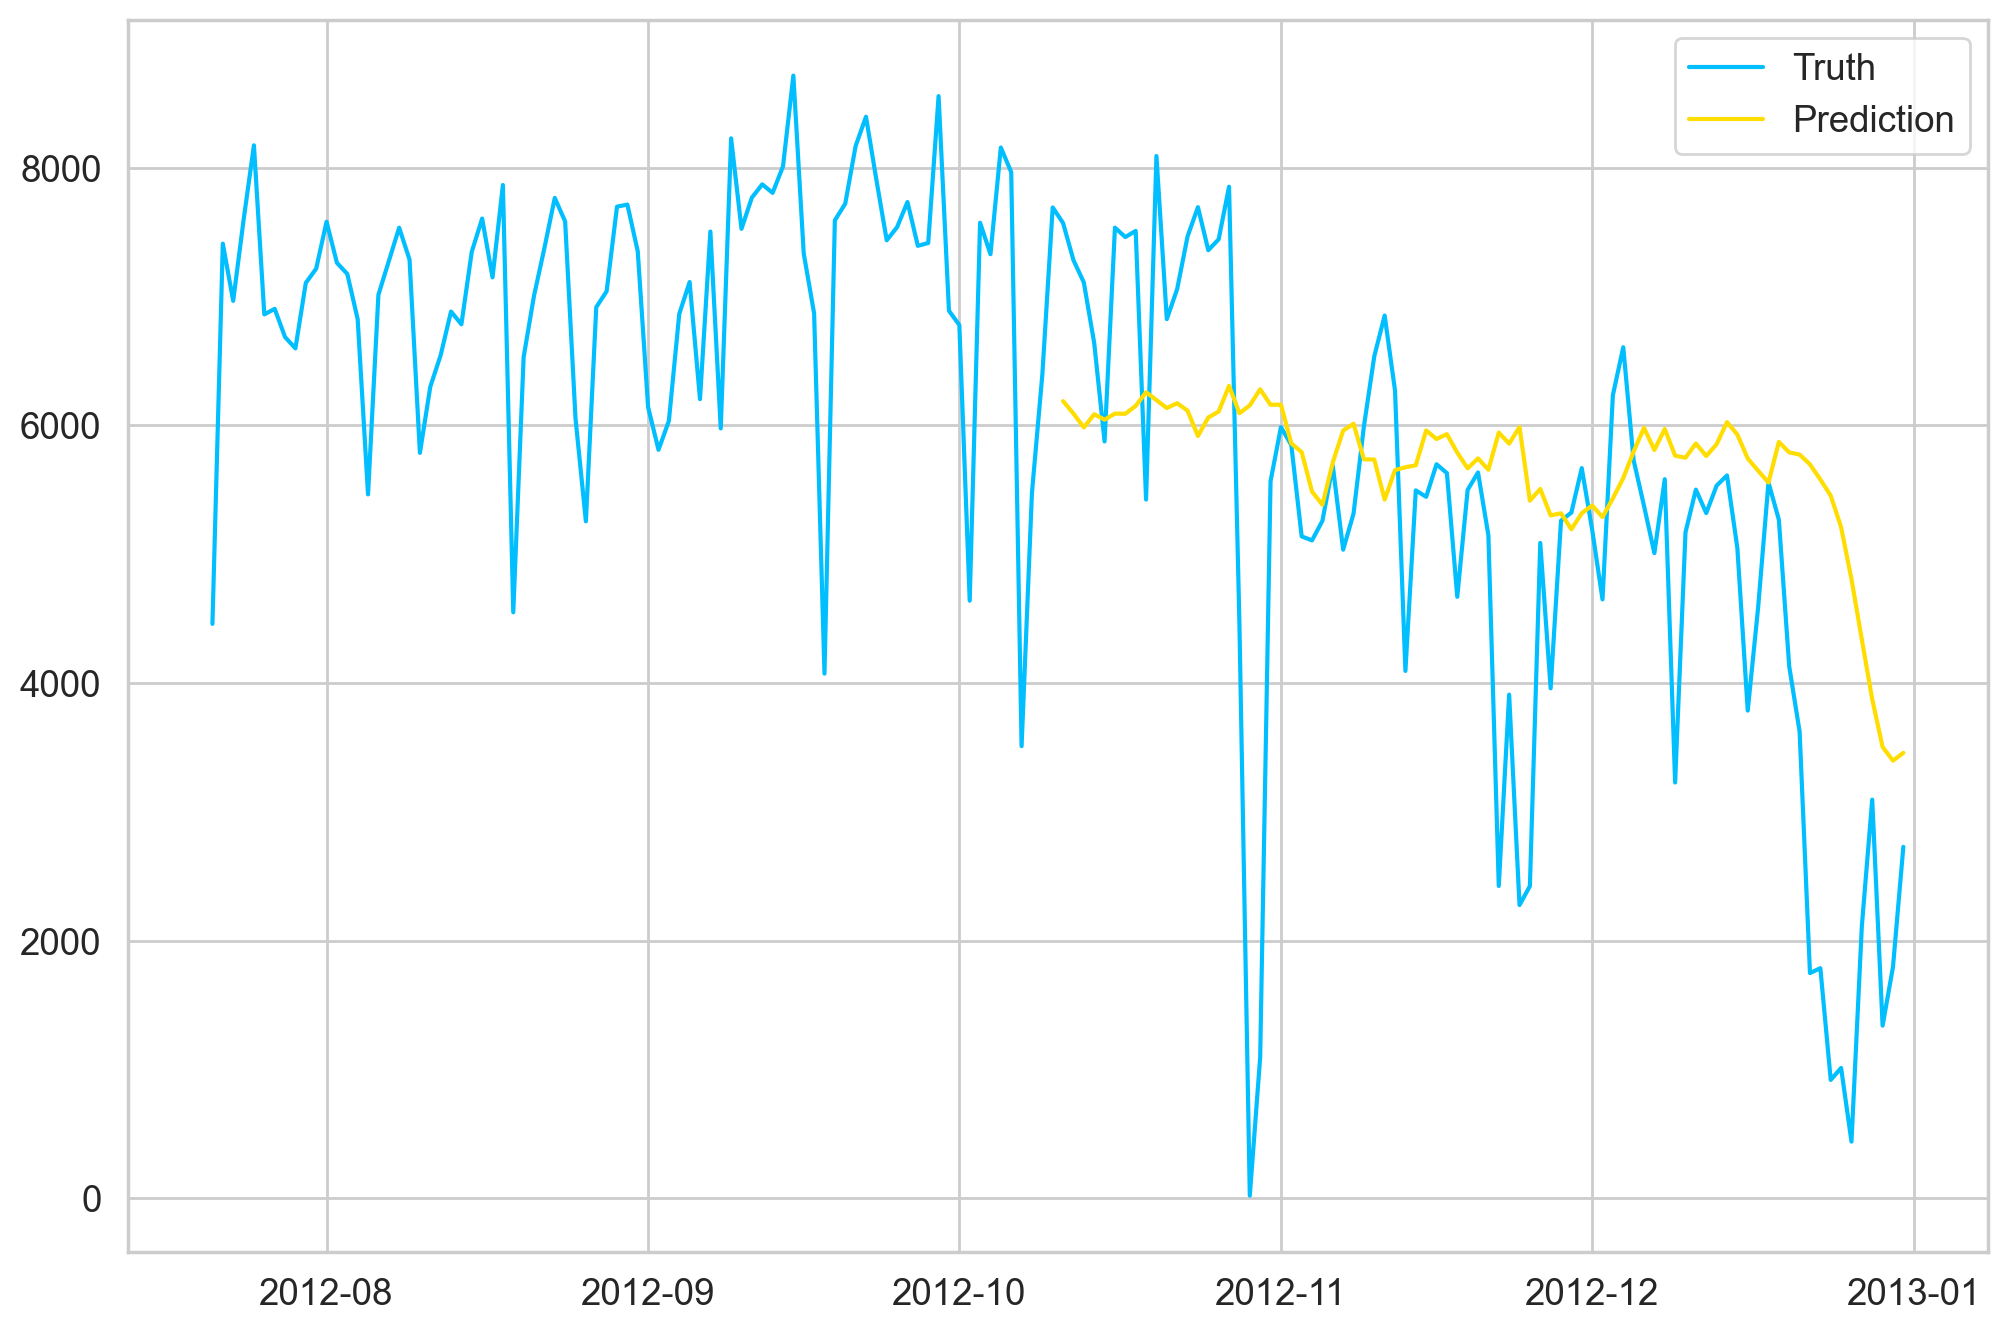

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 121 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
121 K     Trainable params
0         Non-trainable params
121 K     Total params
0.488     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Correlation Threshold:  0.05
Features selected: ['rec_id', 'year', 'month', 'temp', 'atemp', 'humidity', 'windspeed', 'total_count', 'season_1', 'season_2', 'season_3', 'season_4', 'is_workingday_0', 'is_workingday_1', 'is_holiday_0', 'is_holiday_1', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3', 'weekday_0']


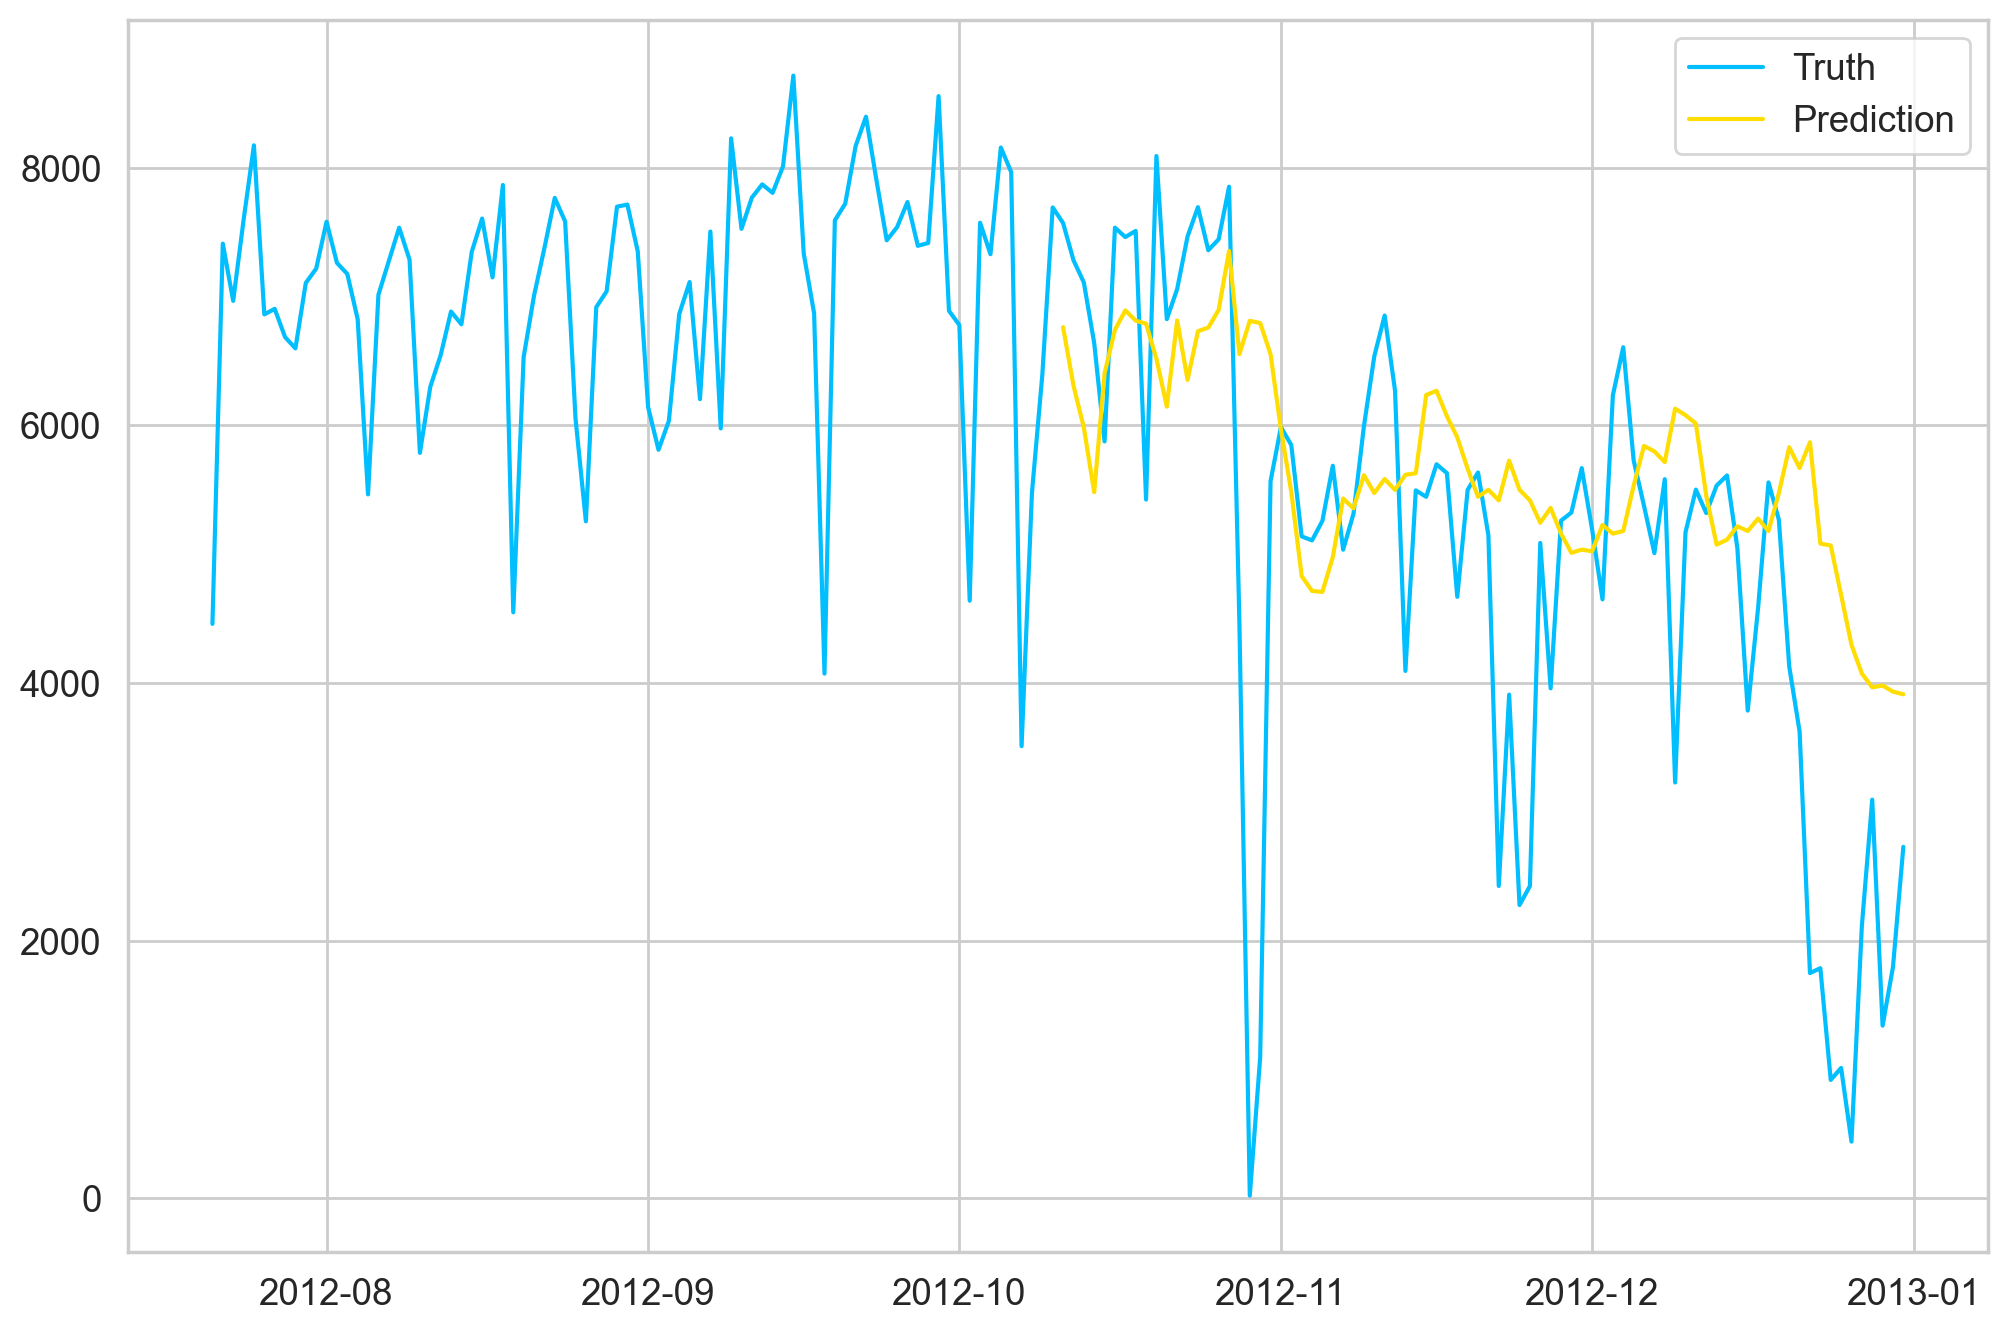

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 120 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.482     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Correlation Threshold:  0.1
Features selected: ['rec_id', 'year', 'month', 'temp', 'atemp', 'humidity', 'windspeed', 'total_count', 'season_1', 'season_2', 'season_3', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3']


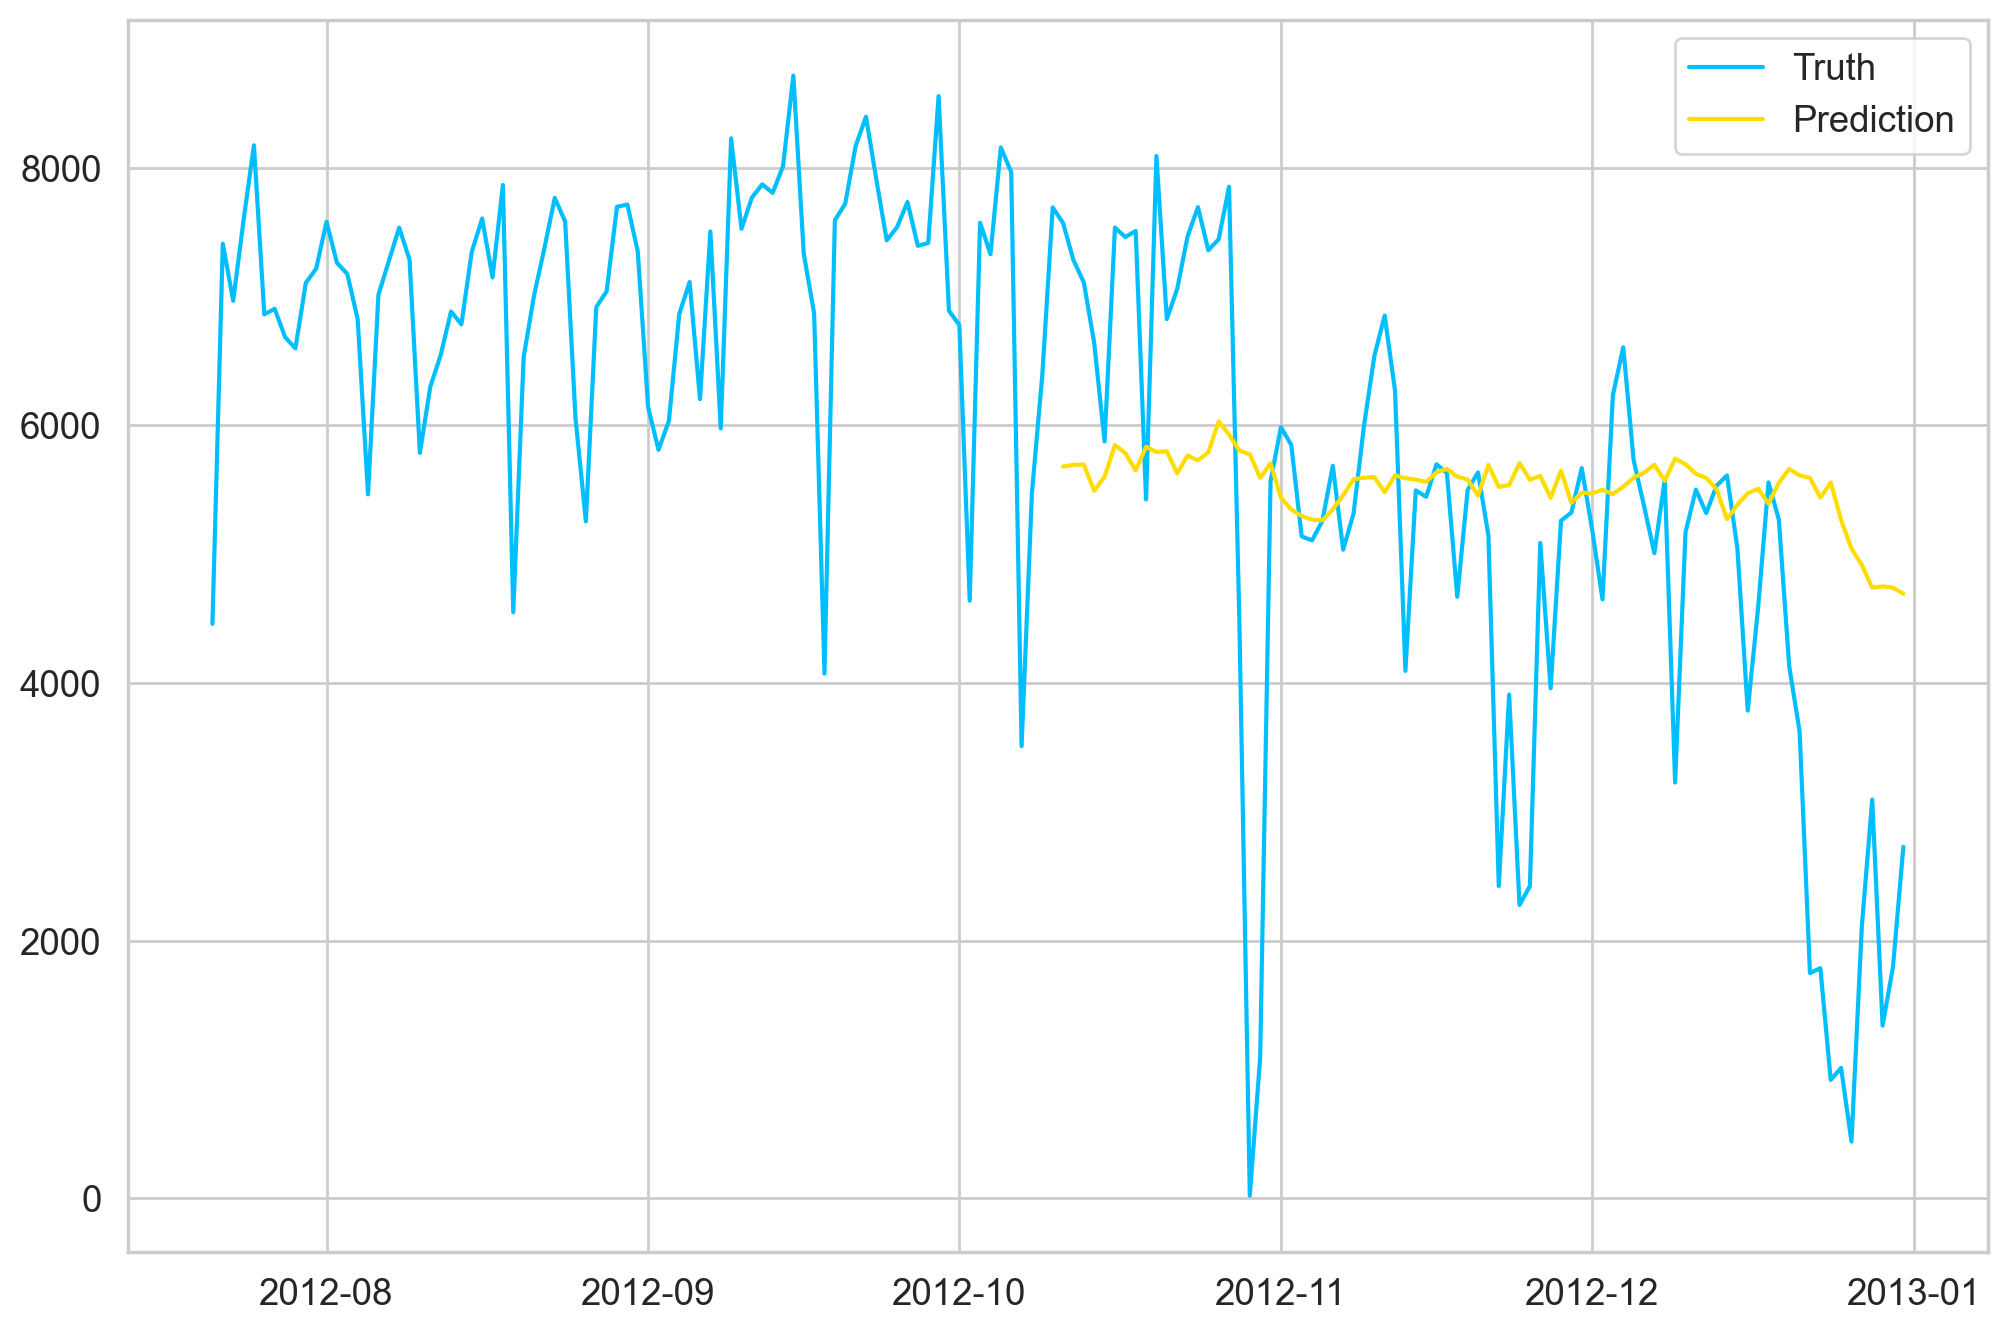

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 119 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.479     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Correlation Threshold:  0.15
Features selected: ['rec_id', 'year', 'month', 'temp', 'atemp', 'windspeed', 'total_count', 'season_1', 'season_3', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3']


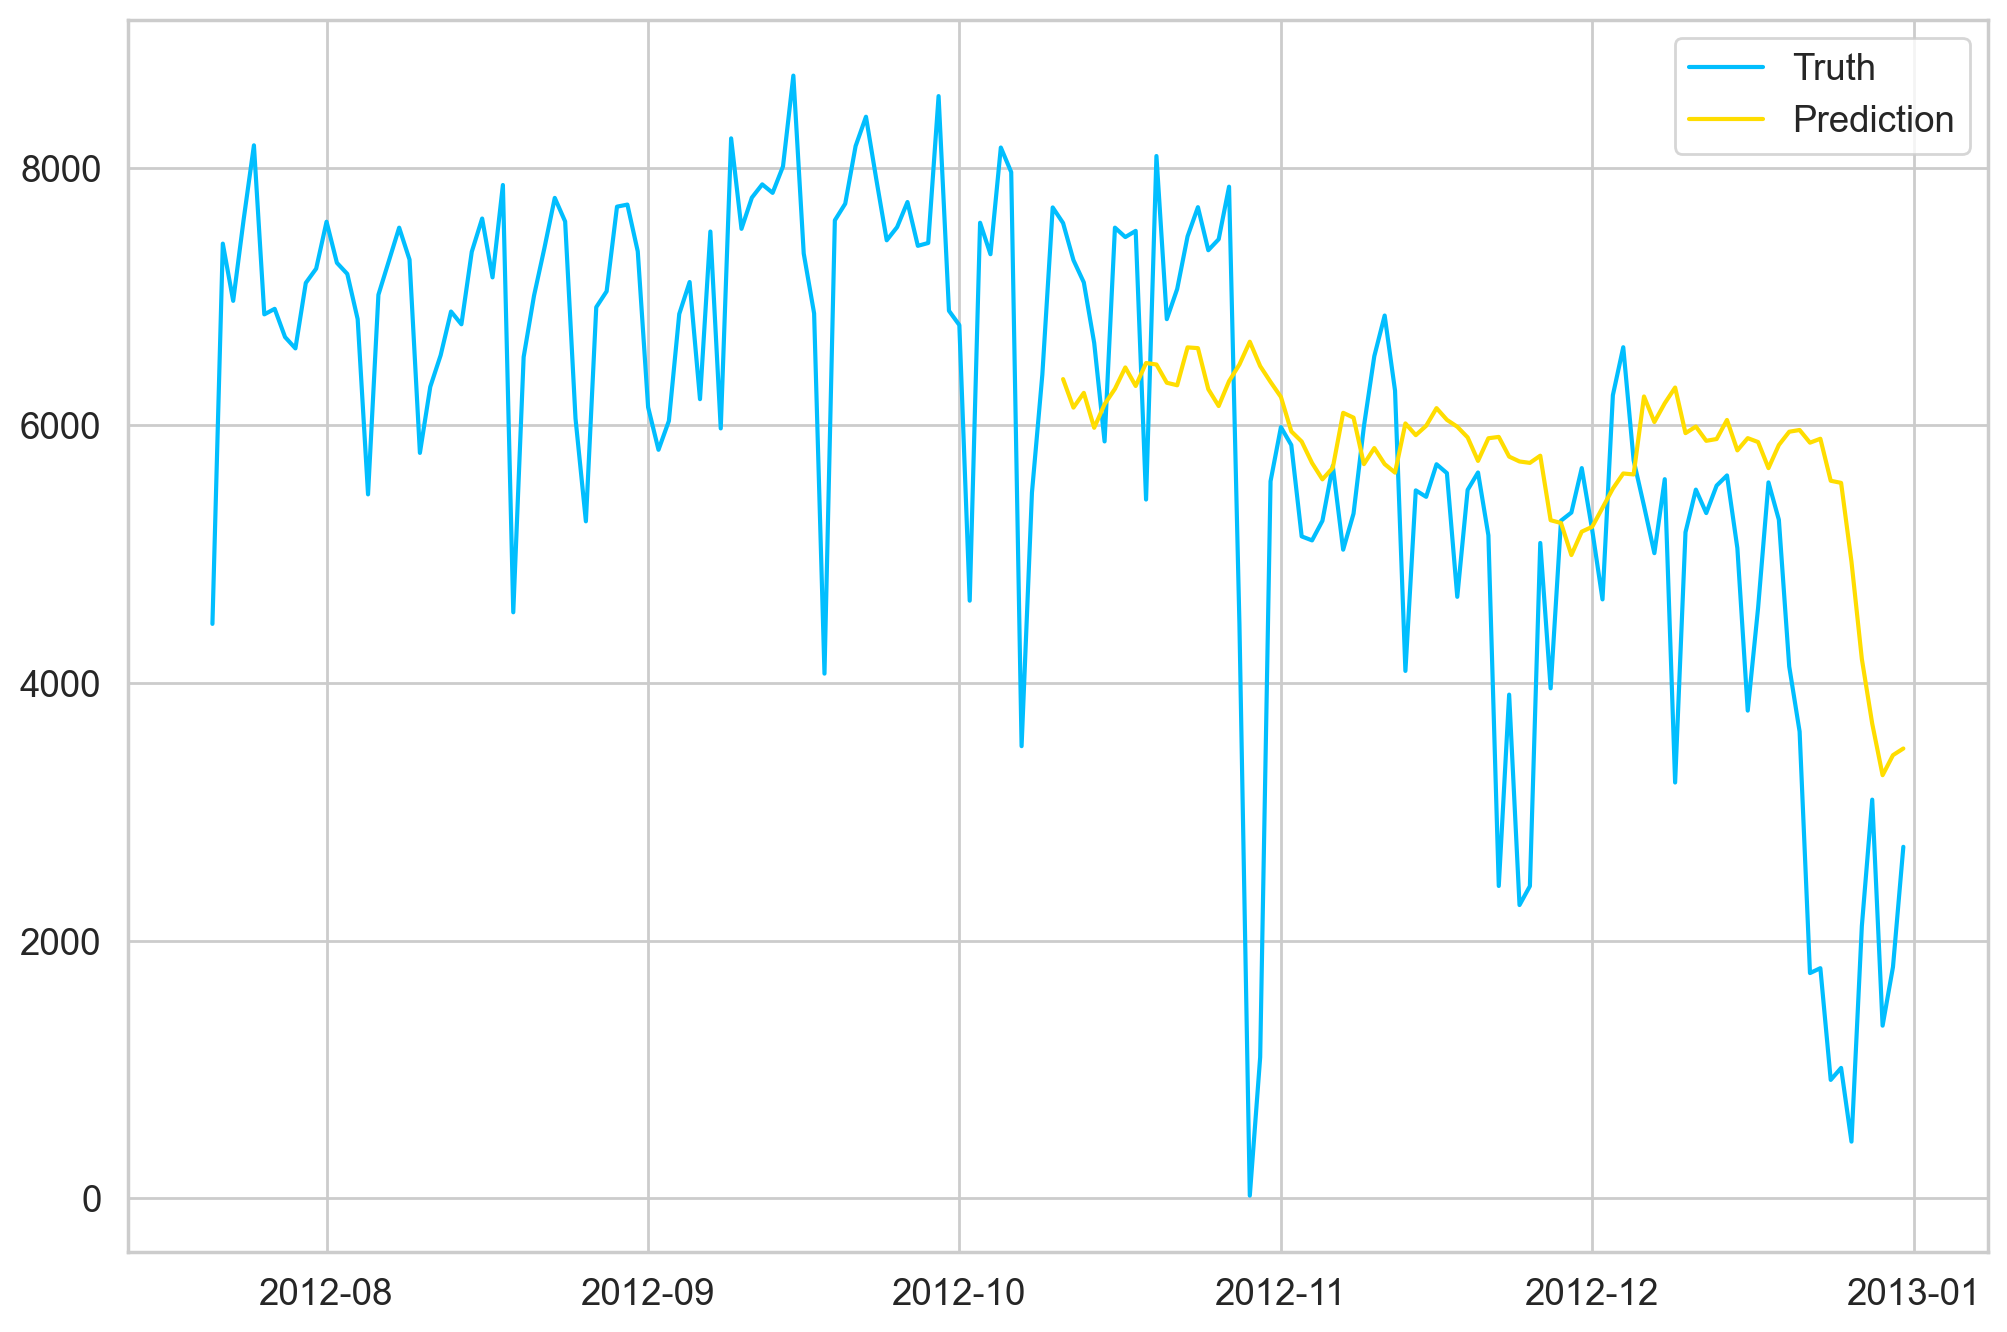

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 119 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.478     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Correlation Threshold:  0.2
Features selected: ['rec_id', 'year', 'month', 'temp', 'atemp', 'windspeed', 'total_count', 'season_1', 'season_3', 'weather_condition_1', 'weather_condition_3']


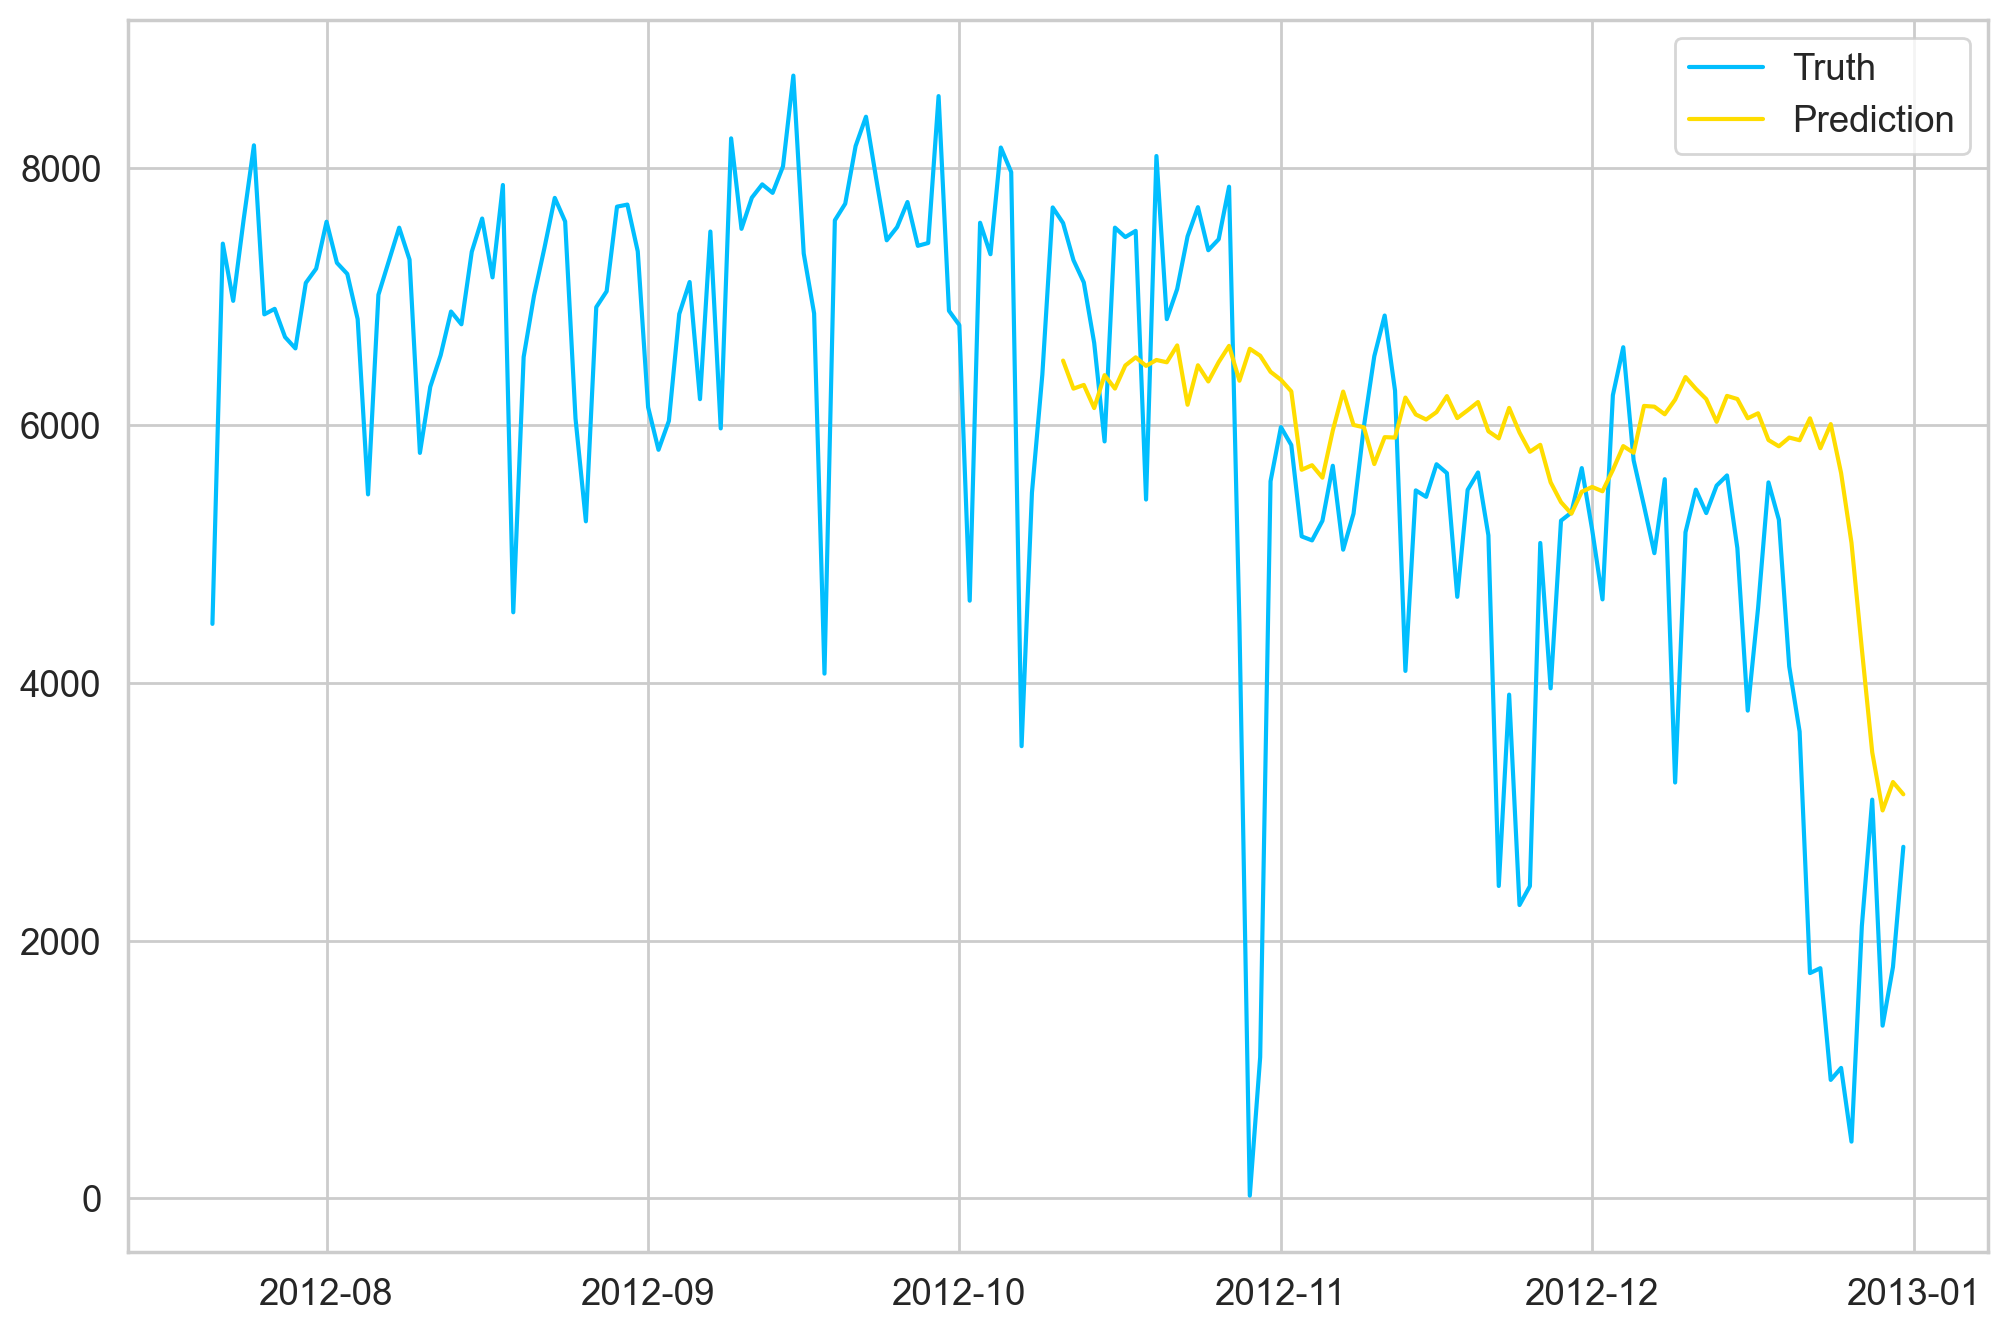

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 119 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.476     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Correlation Threshold:  0.25
Features selected: ['rec_id', 'year', 'month', 'temp', 'atemp', 'total_count', 'season_1', 'season_3', 'weather_condition_1']


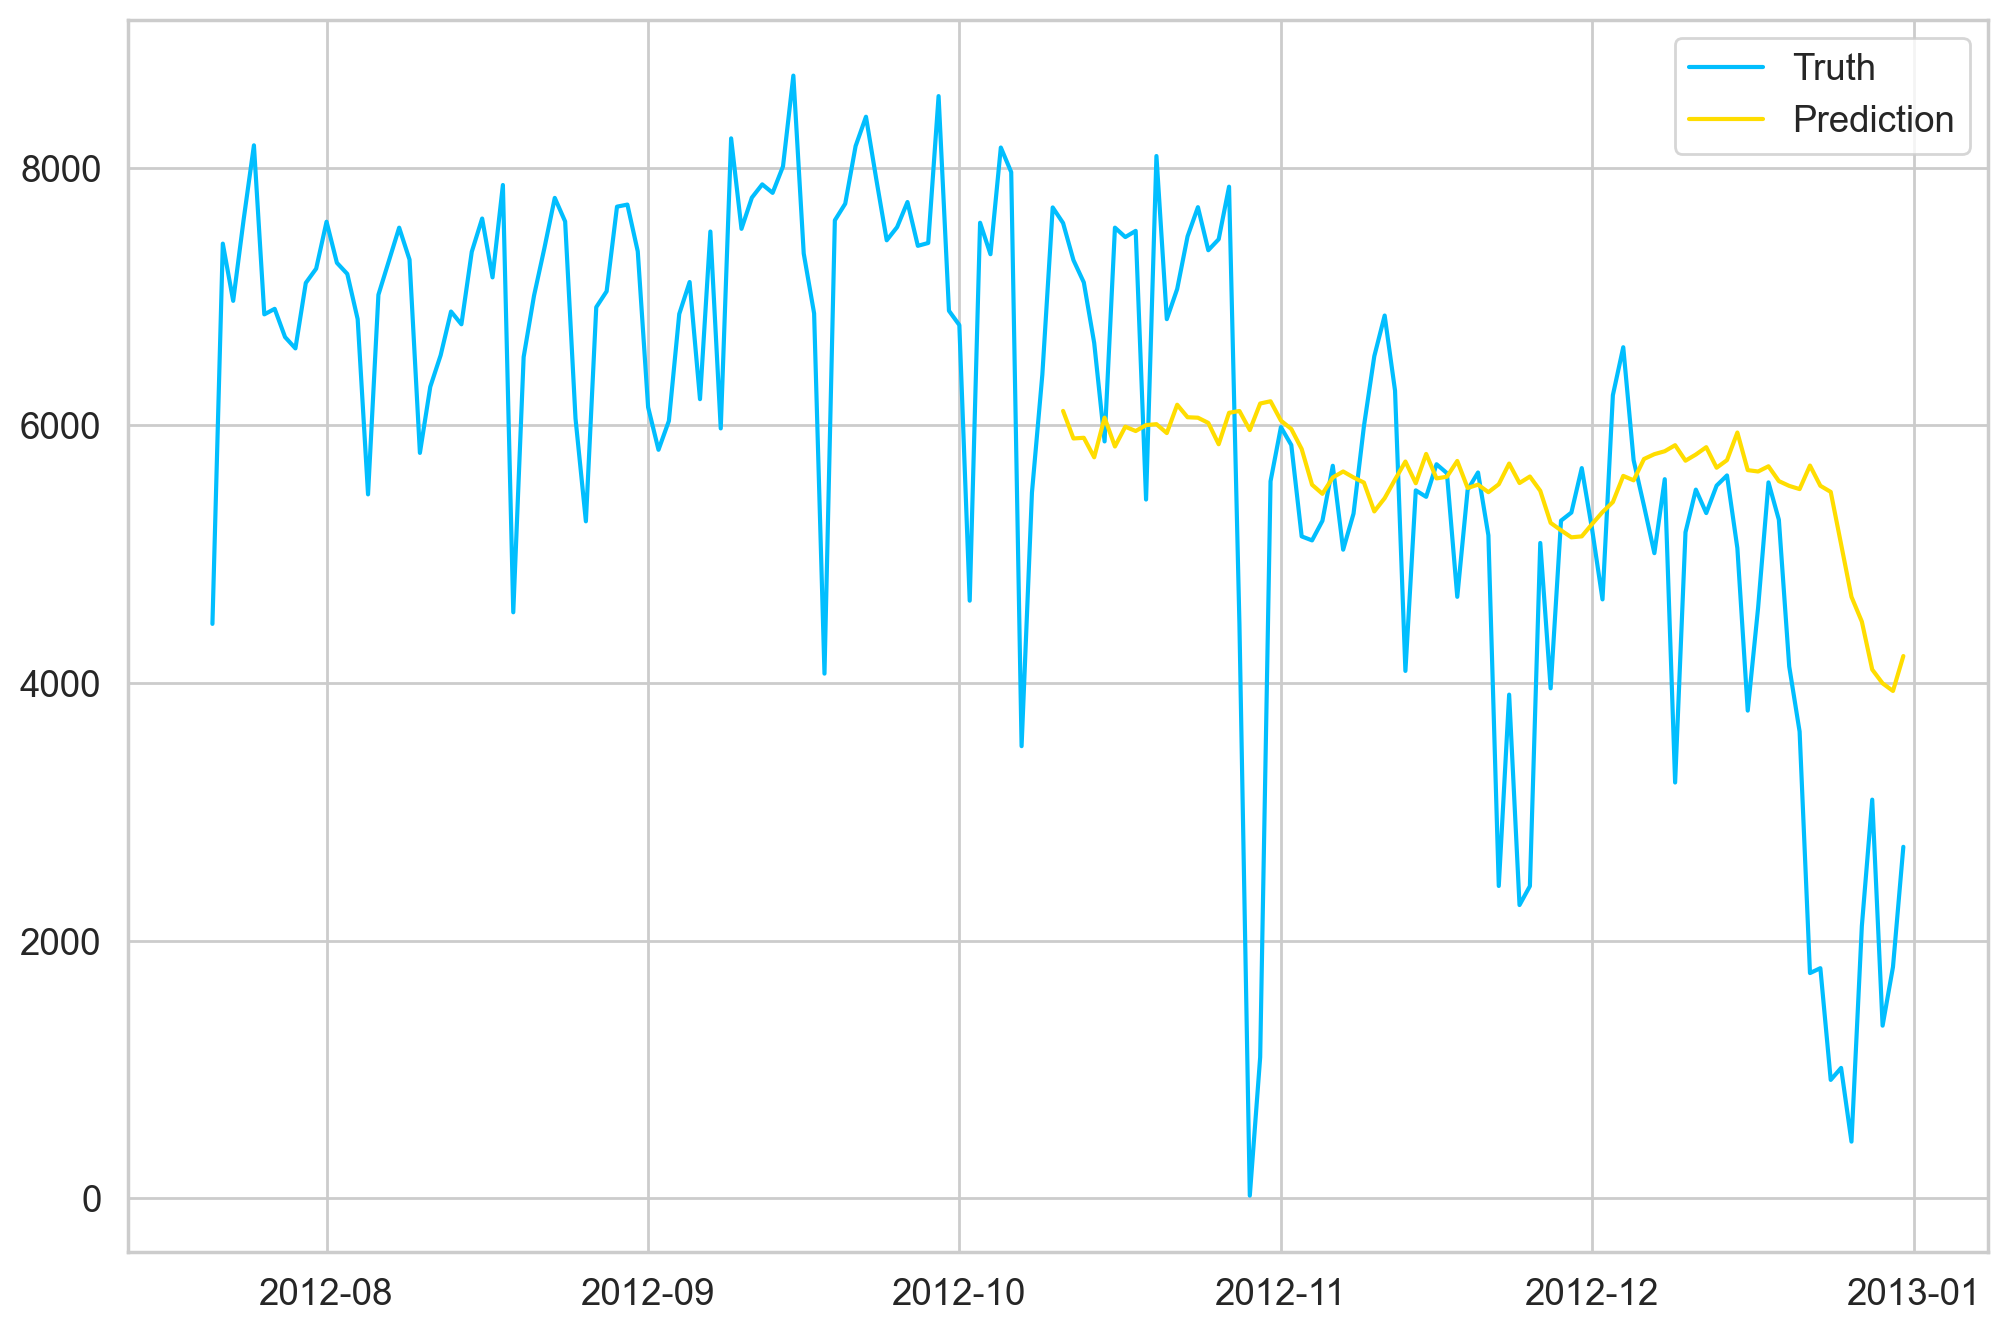

In [8]:
error_ds = []

for cor_th in corr_values:
    Rental_dependencies = {}   
    
    Rental_corr = Bikes_df.corr()[abs(Bikes_df.corr()) > cor_th]
    Rental_dependencies['Sharing'] = Rental_corr[Rental_corr['total_count'].notnull()].index
      
    dic = {}

    features_df = features_dataframe(Bikes_df, Rental_dependencies['Sharing'])

    train_df, test_df, train_size =  train_test_spliter(99,features_df)

    train_df, test_df, scaler = data_scaler(train_df,test_df)

    train_sequences = create_sequences (train_df,'total_count',SEQUENCE_LENGTH)
    test_sequences = create_sequences (test_df,'total_count',SEQUENCE_LENGTH)

    data_module = BTCPriceDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)

    data_module.setup()

    train_dataset = BTCDataset(train_sequences)

    model = BTCPricePredictor(n_features = train_df.shape[1])

    try:
        os.remove(f"{folder_path}/Checkpoints/Bike_sharing_Correlation.ckpt")
    except:
        pass
    
    checkpoint_callback = ModelCheckpoint(
        dirpath = f'{folder_path}/Checkpoints',
        filename = f'Bike_sharing_Correlation',
        save_top_k = 1,
        verbose = False ,
        monitor = 'val_loss',
        mode = 'min'
    )

    logger = TensorBoardLogger('lightning_logs', name = 'btc-price')
    early_stopping_callback = EarlyStopping(monitor= 'val_loss', patience = PATIENCE)

    trainer = pl.Trainer(
        logger = logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs = N_EPOCHS,
        gpus = 0,
    )
    trainer.fit(model, data_module)

    trained_model = BTCPricePredictor.load_from_checkpoint(
    f'{folder_path}/Checkpoints/Bike_sharing_Correlation.ckpt',
    n_features = train_df.shape[1]
    )

    test_dataset = BTCDataset(test_sequences)

    predictions = []
    labels = []


    for item in test_dataset:
        sequence = item['sequence']
        label = item['label']
        _, output = trained_model(sequence.unsqueeze(dim=0))
        predictions.append(output.item())
        labels.append(label.item())


    descaler = MinMaxScaler()
    descaler.min_, descaler.scale_ = scaler.min_[0], scaler.scale_[0]

    predictions_descaled = descale(descaler,predictions)
    labels_descaled = descale(descaler,labels)

    test_data = Bikes_df[train_size+1:]
    test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]

    dates = matplotlib.dates.date2num(test_sequences_data.datetime.tolist())
    full_dates = matplotlib.dates.date2num(Bikes_df.datetime.tolist())

    predictions_descaled = np.where(predictions_descaled<0, 0, predictions_descaled)


    dic = {}

    dic[f'store_truth'] = Bikes_df['total_count']
    dic[f'store_truth_dates'] = full_dates
    truth_df = pd.DataFrame.from_dict(dic)
    truth_df.to_csv(f"{folder_path}/truth.csv",index = False)

    dic= {}

    dic[f'store_pred'] = predictions_descaled
    dic[f'store_pred_dates'] = dates

    prediction_df = pd.DataFrame.from_dict(dic)

    prediction_df.to_csv(f"{folder_path}/prediction{cor_th}.csv",index = False)

    print('Correlation Threshold: ', cor_th)
    print('Features selected:',list(Rental_dependencies['Sharing']))
    plt.plot_date(truth_df.iloc[-2*len(prediction_df):,1],truth_df.iloc[-2*len(prediction_df):,0],'-', label='Truth')
    plt.plot_date(prediction_df.iloc[:,1],prediction_df.iloc[:,0],'-',label ='Prediction')
    plt.legend()
    plt.show();